In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
# import albumentations as A # Library for augmentations
import os
import cv2
import json
import time
import random
import argparse
import numpy as np
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt

#Very hacky fix to make matplotlib work on my pc
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

# repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
repo_dir = "/home/fsuser/3dGolfPoseDetection/"

save_dir = repo_dir + "/dev-nbs/saved-labels/"
downloaded_dir = repo_dir + "downloaded-data/"

### Hyperparameters
batch_size = 3

batch[0] list containing 28 tensors of shape torch.Size([3, 800, 800]):
batch[1] list containing 28 of the following:
'boxes': torch.Size([1, 4]), torch.float32
'labels': torch.Size([1]), torch.int64
'keypoints': torch.Size([1, 2, 3]), torch.float32


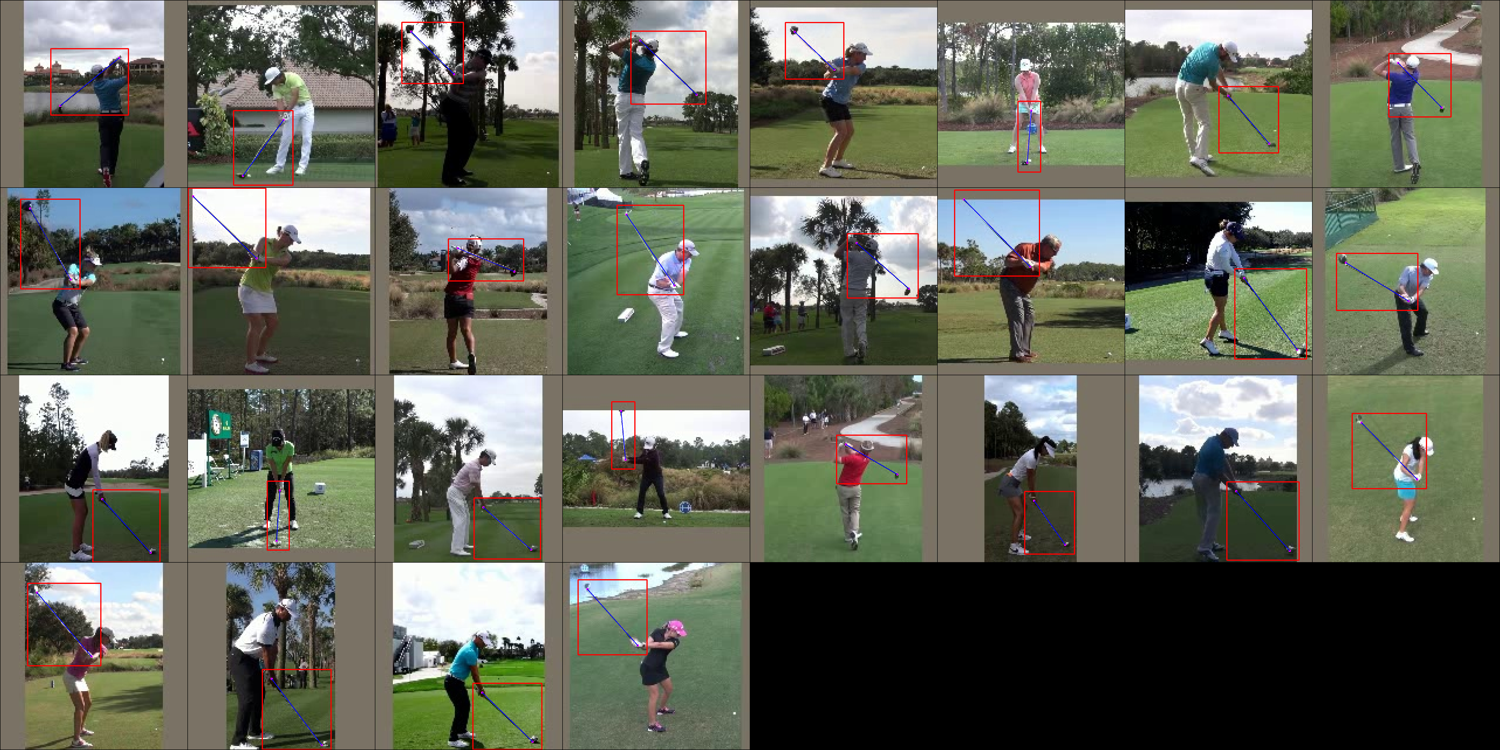

In [2]:
def label_img(img, grip, club, box_cords, line_width=4):
    labelled = img.copy()
    labelled = labelled[:, :, ::-1].astype(np.uint8)
    cv2.circle(labelled, grip[:2], 5, (255,0,255), -1)
    cv2.circle(labelled, club[:2], 5, (255,0,255), -1)
    cv2.line(labelled, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return np.array(labelled)[:,:,::-1]

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, save_dir, device = torch.device("cpu"), annotate = False,):
        self.save_dir = save_dir
        self.filenames = os.listdir(save_dir)
        self.annotate = annotate
        self.device = device
        self.img_transforms = transforms.ToTensor()

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img = np.asarray(Image.open(self.save_dir+filename))
        cords = [int(x) for x in filename.split("_")[1].split("-")]
        grip, club = cords[:2], cords[2:]
        box_buffer = max(img.shape[:2])//20
        box_cords = [
            max(min(grip[0], club[0])-box_buffer, 1),
            max(min(grip[1], club[1])-box_buffer, 1), #top left cord
            min(max(grip[0], club[0])+box_buffer, img.shape[0]-1),
            min(max(grip[1], club[1])+box_buffer, img.shape[1]-1)] # bottom right cord

        if self.annotate:
            img = label_img(img, grip, club, box_cords)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        
        grip.append(1.)
        club.append(1.)
        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64).to(self.device)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)

        img = Image.fromarray(img)
        img = self.img_transforms(img).to(self.device)

        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

batch_size = 32

filenames = os.listdir(save_dir)
dataset = GolfDataset(save_dir, device = device, annotate=True)
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
batch = next(iter(dataloader))

print(f"batch[0] list containing {len(batch[0])} tensors of shape {batch[0][0].shape}:")
print(f"batch[1] list containing {len(batch[1])} of the following:")
for key in batch[1][0]:
    print(f"'{key}': {batch[1][0][key].shape}, {batch[1][0][key].dtype}")

display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0).cpu(), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (1500, 1500)))

In [3]:
def evaluate_model(model, dataloader):
    diffs = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch[0])
            for idx in range(len(preds)):
                prediction_boxes = preds[idx]['boxes']
                if len(prediction_boxes) > 0:
                    real_box = batch[1][idx]['boxes'][0]
                    diff = abs(prediction_box[0] - real_box)
                    diffs.append(diff)

    model.train()

    if len(diffs) == 0:
        return ['inf', 'inf', 'inf', 'inf']
    np_array = torch.stack(diffs,dim=0).cpu().numpy()
    averages = np.mean(np_array, axis=0)
    return [round(x, 4) for x in averages]

In [14]:
batch = next(iter(dataloader))

In [15]:
model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out
model = model.to(device)

In [20]:
model.eval()
preds = model(batch[0])
preds

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'keypoints': tensor([], device='cuda:0', size=(0, 2, 3)),
  'keypoints_scores': tensor([], device='cuda:0', size=(0, 2))},
 {'boxes': tensor([[560.0381, 448.3692, 565.5311, 456.1207],
          [558.4844, 448.6260, 563.5577, 456.9263]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.2749, 0.1213], device='cuda:0', grad_fn=<IndexBackward0>),
  'keypoints': tensor([[[562.3268, 453.6984,   1.0000],
           [562.3268, 455.6363,   1.0000]],
  
          [[560.5983, 453.6984,   1.0000],
           [560.5983, 456.4652,   1.0000]]], device='cuda:0',
         grad_fn=<CopySlices>),
  'keypoints_scores': tensor([[0.9144, 5.6759],
          [0.6223, 5.7626]], device='cuda:0', grad_fn=<CopySlices>)},
 {'boxes': tensor(

In [21]:
diffs = []

model.eval()
with torch.no_grad():
    for batch in dataloader:
        preds = model(batch[0])
        for idx in range(len(preds)):
            prediction_boxes = preds[idx]['boxes']
            if len(prediction_boxes) > 0:
                real_box = batch[1][idx]['boxes'][0]
                diff = abs(prediction_boxes[0] - real_box)
                diffs.append(diff)

model.train()

if len(diffs) == 0:
    print(['inf', 'inf', 'inf', 'inf'])
np_array = torch.stack(diffs,dim=0).cpu().numpy()
averages = np.mean(np_array, axis=0)
print([round(x, 4) for x in averages])

[245.4811, 163.6776, 210.8652, 173.4095]


In [22]:
#freeze parameters in backbone
for param in model.backbone.parameters():
    param.requires_grad = False

#{'boxes': tensor([[560.0381, 448.3692, 565.5311, 456.1207],
##### Hyperparameters #####
iterations = 50
lr = 0.00003

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)

keys_to_train = ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']

losses = []

model.train()
for i in range(iterations):
    losses_dict = model(*batch)
    # total_loss = sum([losses_dict[key] for key in losses_dict.keys()]) #  'loss_keypoint'
    total_loss = sum([losses_dict[key] for key in keys_to_train]) #  'loss_keypoint'
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    losses.append([losses_dict[key].item() for key in keys_to_train])

    if i % 10 == 0:
        print(f"iteration {i}: {total_loss.item():.2f} | {''.join([f'{key}: {losses_dict[key].item():.4f} | ' for key in keys_to_train])}")
        
    # if i % 50 == 0:
    #     print(f"evaluation of bbox: {evaluate_model(model, dataloader)}")

iteration 0: 0.34 | loss_classifier: 0.1740 | loss_box_reg: 0.0682 | loss_objectness: 0.0952 | loss_rpn_box_reg: 0.0050 | 
iteration 10: 0.16 | loss_classifier: 0.0478 | loss_box_reg: 0.0664 | loss_objectness: 0.0408 | loss_rpn_box_reg: 0.0038 | 
iteration 20: 0.12 | loss_classifier: 0.0303 | loss_box_reg: 0.0623 | loss_objectness: 0.0195 | loss_rpn_box_reg: 0.0038 | 
iteration 30: 0.11 | loss_classifier: 0.0241 | loss_box_reg: 0.0720 | loss_objectness: 0.0152 | loss_rpn_box_reg: 0.0026 | 
iteration 40: 0.10 | loss_classifier: 0.0198 | loss_box_reg: 0.0676 | loss_objectness: 0.0121 | loss_rpn_box_reg: 0.0023 | 


In [ ]:
#[245.4811, 163.6776, 210.8652, 173.4095]

In [23]:
diffs = []

model.eval()
with torch.no_grad():
    for batch in dataloader:
        preds = model(batch[0])
        for idx in range(len(preds)):
            prediction_boxes = preds[idx]['boxes']
            if len(prediction_boxes) > 0:
                real_box = batch[1][idx]['boxes'][0]
                diff = abs(prediction_boxes[0] - real_box)
                diffs.append(diff)

model.train()

if len(diffs) == 0:
    print(['inf', 'inf', 'inf', 'inf'])
np_array = torch.stack(diffs,dim=0).cpu().numpy()
averages = np.mean(np_array, axis=0)
print([round(x, 4) for x in averages])

[9.0178, 13.7313, 12.8778, 13.4578]


In [13]:
model.eval()
preds = model(batch[0])
preds

[{'boxes': tensor([[227.8835, 214.2530, 546.1724, 482.5422],
          [182.4742, 218.0315, 534.0587, 367.5097],
          [157.2162, 254.0051, 453.3918, 517.5982],
          [369.4920, 246.2142, 618.9126, 429.7932],
          [453.4117, 495.6791, 686.4789, 800.0000],
          [109.3013, 475.3926, 685.4050, 800.0000],
          [121.0308, 167.0917, 338.0097, 480.2393],
          [116.4023, 158.6147, 526.0840, 332.8889],
          [416.6495, 210.3058, 556.2778, 357.9437],
          [202.7910, 190.0800, 319.9566, 414.9880]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9478, 0.9116, 0.7475, 0.5117, 0.1727, 0.1378, 0.0747, 0.0732, 0.0585,
          0.0507], device='cuda:0', grad_fn=<IndexBackward0>),
  'keypoints': tensor([[[472.8362, 305.5113,   1.0000],
           [228.3824, 401.2576,   1.0000]],
  
          [[478.6242, 268.3559,   1.0000],
           [238.9075, 343.0950,   1.0000]],
  


In [106]:
losses = np.array(losses)

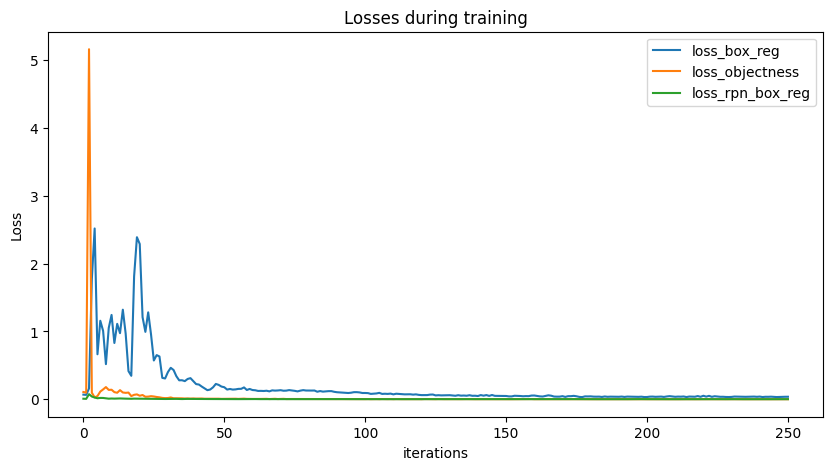

In [115]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
# keys_to_train = [(0, 'loss_classifier'), (1, 'loss_box_reg'), (2, 'loss_objectness'), (3, 'loss_rpn_box_reg')]
keys_to_display = [(1, 'loss_box_reg'), (2, 'loss_objectness'), (3, 'loss_rpn_box_reg')]
for (i, key) in keys_to_display:
    plt.plot(losses[:,i],label=key)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()